In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch candlestick data from Upbit
def fetch_upbit_candles(market, to_time, count=200, minute_unit=1):
    url = f"https://api.upbit.com/v1/candles/minutes/{minute_unit}"
    params = {
        'market': market,
        'to': to_time,
        'count': count  # Maximum 200 per request
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data from Upbit: {response.status_code}")
        return []

# Function to get historical data for a given date range
def get_upbit_data(market, start_time, end_time, minute_unit=1):
    all_data = []
    current_time = end_time

    while current_time > start_time:
        # Fetch 200 candles at a time, each request goes backwards from `current_time`
        candles = fetch_upbit_candles(market, current_time.strftime("%Y-%m-%dT%H:%M:%S"), minute_unit=minute_unit)
        
        if not candles:
            print("No more data or an error occurred.")
            break
        
        # Convert the UTC timestamp to a datetime object and add to the list
        for candle in candles:
            candle['candle_date_time_utc'] = datetime.strptime(candle['candle_date_time_utc'], "%Y-%m-%dT%H:%M:%S")
        
        all_data.extend(candles)
        
        # Update `current_time` to the oldest candle timestamp to continue paginating
        current_time = all_data[-1]['candle_date_time_utc'] - timedelta(minutes=1)

        # Stop when we go past the start_time
        if current_time < start_time:
            break

    return all_data

# Define the time range for September 13, 2024 (in UTC)
start_time = datetime(2024, 9, 13, 0, 0, 0)  # Start of the day (UTC)
end_time = datetime(2024, 9, 13, 23, 59, 59)  # End of the day (UTC)

# Fetch CKB/KRW 1-minute interval data from Upbit
ckb_data = get_upbit_data("KRW-CKB", start_time, end_time, minute_unit=1)

# Convert CKB/KRW data into a pandas DataFrame
ckb_df = pd.DataFrame(ckb_data)
ckb_df = ckb_df[['candle_date_time_utc', 'opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume']]
ckb_df['candle_date_time_utc'] = pd.to_datetime(ckb_df['candle_date_time_utc'])

# Fetch USDT/KRW 1-minute interval data from Upbit
usdt_data = get_upbit_data("KRW-USDT", start_time, end_time, minute_unit=1)

# Convert USDT/KRW data into a pandas DataFrame
usdt_df = pd.DataFrame(usdt_data)
usdt_df = usdt_df[['candle_date_time_utc', 'trade_price']]
usdt_df['candle_date_time_utc'] = pd.to_datetime(usdt_df['candle_date_time_utc'])

# Merge the two dataframes on the timestamp
merged_df = pd.merge(ckb_df, usdt_df, on='candle_date_time_utc', suffixes=('_ckb', '_usdt'))

# Calculate CKB price in USD (CKB/KRW divided by USDT/KRW)
merged_df['CKB_in_USD'] = merged_df['trade_price_ckb'] / merged_df['trade_price_usdt']

# Save the result to CSV
merged_df.to_csv("ckb_usd_2024_09_13.csv", index=False)
print("CKB price in USD for September 13, 2024, saved.")

No more data or an error occurred.
CKB price in USD for September 13, 2024, saved.


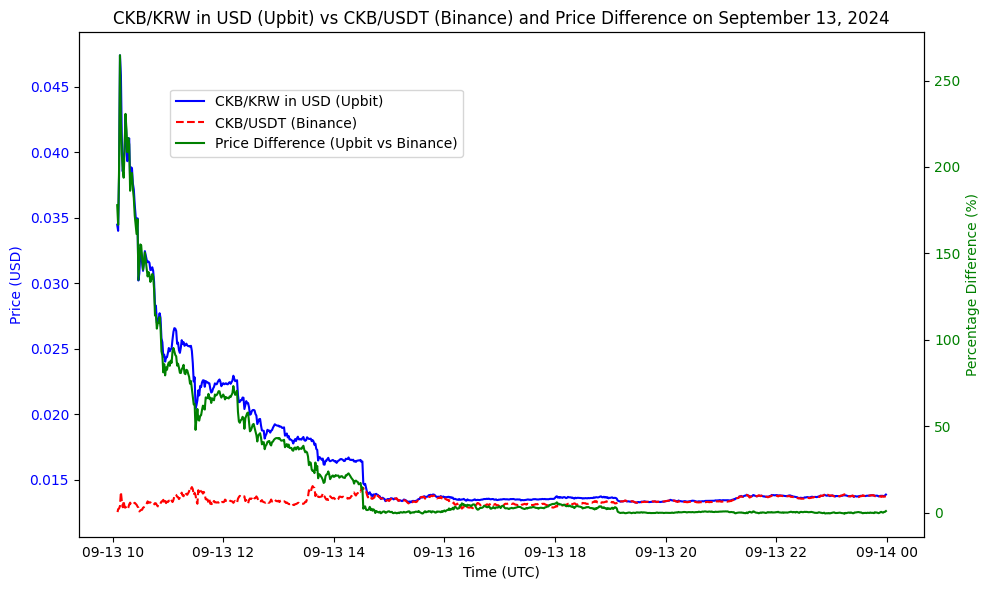

In [8]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from binance.client import Client

# Your Binance API credentials
api_key = 'Ta0xEGr3ogYlT7L4hxzgMV8zIOxDGChCqbdHuV1ZxG6pqCtdvSJ1KS5ZMq2XX9Uk'
api_secret = 'JqwryeIAHF1aISI0G1Z4X8zIRwU9YIoUIWCq3OOC3OpZrs1BMi1i7iv369aDZTp4'

# Initialize the Binance client
client = Client(api_key, api_secret)

# Function to fetch Binance historical data
def get_binance_data(symbol, interval, start_time, end_time):
    klines = client.get_historical_klines(symbol, interval, start_time, end_time)
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_time',
        'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['Close'] = df['Close'].astype(float)  # Convert Close to float for plotting
    return df

# Define the time range for September 13, 2024 (in UTC)
start_time = "2024-09-13 00:00:00"
end_time = "2024-09-13 23:59:59"

# Fetch CKB/USDT 1-minute interval data from Binance
binance_df = get_binance_data("CKBUSDT", Client.KLINE_INTERVAL_1MINUTE, start_time, end_time)

# Assuming you've already fetched CKB/KRW and USDT/KRW from Upbit and calculated CKB in USD
# The merged dataframe should be ready (from the previous step)
# merged_df should contain a column 'CKB_in_USD' (CKB in USD from Upbit) and 'candle_date_time_utc'

# Align the Binance and Upbit dataframes on timestamps
# Rename 'timestamp' in Binance data to match the column in the Upbit data
binance_df = binance_df.rename(columns={'timestamp': 'candle_date_time_utc'})
merged_df['candle_date_time_utc'] = pd.to_datetime(merged_df['candle_date_time_utc'])

# Merge Binance data (CKB/USDT) with Upbit data (CKB in USD)
final_df = pd.merge(merged_df[['candle_date_time_utc', 'CKB_in_USD']], binance_df[['candle_date_time_utc', 'Close']], on='candle_date_time_utc', suffixes=('_upbit', '_binance'))

import matplotlib.pyplot as plt

# Calculate the percentage difference between CKB/KRW in USD and CKB/USDT from Binance
final_df['price_diff_pct'] = ((final_df['CKB_in_USD'] - final_df['Close']) / final_df['Close']) * 100

# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the CKB/KRW in USD (Upbit) and CKB/USDT (Binance) on the first y-axis (left)
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.plot(final_df['candle_date_time_utc'], final_df['CKB_in_USD'], label='CKB/KRW in USD (Upbit)', color='blue')
ax1.plot(final_df['candle_date_time_utc'], final_df['Close'], label='CKB/USDT (Binance)', linestyle='--', color='red')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis (right) for the percentage difference
ax2 = ax1.twinx()
ax2.set_ylabel('Percentage Difference (%)', color='green')
ax2.plot(final_df['candle_date_time_utc'], final_df['price_diff_pct'], label='Price Difference (Upbit vs Binance)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add titles and legends
plt.title('CKB/KRW in USD (Upbit) vs CKB/USDT (Binance) and Price Difference on September 13, 2024')

# Display both legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Tight layout to ensure no overlap
plt.tight_layout()

# Display the plot
plt.show()

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch candlestick data from Upbit
def fetch_upbit_candles(market, to_time, count=200, minute_unit=1):
    url = f"https://api.upbit.com/v1/candles/minutes/{minute_unit}"
    params = {
        'market': market,
        'to': to_time,
        'count': count  # Maximum 200 per request
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data from Upbit: {response.status_code}")
        return []

# Function to get historical data for a given date range
def get_upbit_data(market, start_time, end_time, minute_unit=1):
    all_data = []
    current_time = end_time

    while current_time > start_time:
        # Fetch 200 candles at a time, each request goes backwards from `current_time`
        candles = fetch_upbit_candles(market, current_time.strftime("%Y-%m-%dT%H:%M:%S"), minute_unit=minute_unit)
        
        if not candles:
            print("No more data or an error occurred.")
            break
        
        # Convert the UTC timestamp to a datetime object and add to the list
        for candle in candles:
            candle['candle_date_time_utc'] = datetime.strptime(candle['candle_date_time_utc'], "%Y-%m-%dT%H:%M:%S")
        
        all_data.extend(candles)
        
        # Update `current_time` to the oldest candle timestamp to continue paginating
        current_time = all_data[-1]['candle_date_time_utc'] - timedelta(minutes=1)

        # Stop when we go past the start_time
        if current_time < start_time:
            break

    return all_data

# Define the time range for September 13, 2024 (in UTC)
start_time = datetime(2024, 9, 13, 0, 0, 0)  # Start of the day (UTC)
end_time = datetime(2024, 9, 13, 23, 59, 59)  # End of the day (UTC)

# Fetch CKB/KRW 1-minute interval data from Upbit
upbit_data = get_upbit_data("KRW-CKB", start_time, end_time, minute_unit=1)

# Convert the data into a pandas DataFrame
upbit_df = pd.DataFrame(upbit_data)

# Select relevant columns and convert UTC timestamp to datetime format
upbit_df = upbit_df[['candle_date_time_utc', 'opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume']]
upbit_df['candle_date_time_utc'] = pd.to_datetime(upbit_df['candle_date_time_utc'])

# Save to CSV
upbit_df.to_csv("ckb_krw_upbit_2024_09_13.csv", index=False)
print("CKB/KRW data for September 13, 2024, saved.")

No more data or an error occurred.
CKB/KRW data for September 13, 2024, saved.


In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch candlestick data from Upbit
def fetch_upbit_candles(market, to_time, count=200, minute_unit=1):
    url = f"https://api.upbit.com/v1/candles/minutes/{minute_unit}"
    params = {
        'market': market,
        'to': to_time,
        'count': count  # Maximum 200 per request
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data from Upbit: {response.status_code}")
        return []

# Function to get historical data for a given date range
def get_upbit_data(market, start_time, end_time, minute_unit=1):
    all_data = []
    current_time = end_time

    while current_time > start_time:
        # Fetch 200 candles at a time, each request goes backwards from `current_time`
        candles = fetch_upbit_candles(market, current_time.strftime("%Y-%m-%dT%H:%M:%S"), minute_unit=minute_unit)
        
        if not candles:
            print("No more data or an error occurred.")
            break
        
        # Convert the UTC timestamp to a datetime object and add to the list
        for candle in candles:
            candle['candle_date_time_utc'] = datetime.strptime(candle['candle_date_time_utc'], "%Y-%m-%dT%H:%M:%S")
        
        all_data.extend(candles)
        
        # Update `current_time` to the oldest candle timestamp to continue paginating
        current_time = all_data[-1]['candle_date_time_utc'] - timedelta(minutes=1)

        # Stop when we go past the start_time
        if current_time < start_time:
            break

    return all_data

# Define the time range for September 13, 2024 (in UTC)
start_time = datetime(2024, 9, 13, 0, 0, 0)  # Start of the day (UTC)
end_time = datetime(2024, 9, 13, 23, 59, 59)  # End of the day (UTC)

# Fetch USDT/KRW 1-minute interval data from Upbit
upbit_data = get_upbit_data("KRW-USDT", start_time, end_time, minute_unit=1)

# Convert the data into a pandas DataFrame
upbit_df = pd.DataFrame(upbit_data)

# Select relevant columns and convert UTC timestamp to datetime format
upbit_df = upbit_df[['candle_date_time_utc', 'opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume']]
upbit_df['candle_date_time_utc'] = pd.to_datetime(upbit_df['candle_date_time_utc'])

# Save to CSV
upbit_df.to_csv("usdt_krw_upbit_2024_09_13.csv", index=False)
print("USDT/KRW data for September 13, 2024, saved.")

USDT/KRW data for September 13, 2024, saved.
